# Лабораторная работа 3. Apache Spark и анализ данных на GPU
Выполнил: студент гр. АСМ-18-04, Макаров И.Д.

### 1. Apache Spark и параллельные вычисления

In [1]:
# Импортируем необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import findspark
findspark.find()

import pyspark.sql.functions as f
from pyspark.sql import SparkSession, SQLContext

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans

from ipywidgets import IntProgress
from IPython.display import display
import time

In [2]:
# Инициируем сессию Spark
spark = SparkSession.builder.appName('LR3').getOrCreate()

In [3]:
# Файл для анализа данных
filename = 'bp-stats-review-2019-all-data.xlsx'

### 1.1 Знакомство с параллельными вычислениями с Apache Spark

In [53]:
# Подготавливаем необходимую информацию для импорта данных
sheets = ['Oil Consumption - Mtoe',
          'Gas Consumption - Mtoe',
          'Solar Consumption - Mtoe']
header_ = 2
usecols_ = 'A:BC'
skiprows_ = list(range(109,125))

# Импортируем данные
df = pd.read_excel(filename, sheet_name=sheets, header=header_, usecols=usecols_, skiprows=skiprows_)

for sheet in sheets:
    df[sheet].dropna(inplace=True, how='all')
    df[sheet].reset_index(inplace=True, drop=True)

In [4]:
# Примерный вид исходных данных
df[sheets[0]]

,Million tonnes oil equivalent,1965,1966,1967,1968,1969,1970,1971,1972,1973,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Canada,55.272396,58.234069,62.175940,66.190292,68.920491,73.499592,75.481547,79.478321,83.882607,...,99.762396,107.068086,110.367291,107.471962,107.805690,109.646464,106.966207,108.702138,108.796753,109.974271
1,Mexico,15.343793,16.078587,17.220666,18.726045,19.790064,21.278996,22.565501,25.409552,27.192227,...,92.940218,93.343641,94.899632,96.431584,93.758781,89.514740,88.486157,89.128402,85.819769,82.824033
2,US,565.869388,594.152486,617.120100,659.945528,695.892017,723.721235,748.587032,808.809997,853.780970,...,860.588513,877.453257,862.165031,843.835305,859.769126,866.147645,884.512178,893.263915,901.997187,919.729513
3,Total North America,636.485576,668.465142,696.516707,744.861865,784.602573,818.499823,846.634080,913.697870,964.855804,...,1053.291127,1077.864984,1067.431954,1047.738851,1061.333597,1065.308848,1079.964542,1091.094456,1096.613710,1112.527817
4,Argentina,22.367953,23.092416,23.661791,24.162294,25.105912,22.541685,24.073526,24.106384,24.188986,...,25.006119,28.568863,28.852377,30.146814,32.351584,31.916016,32.904958,32.314052,32.036983,30.113779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Taiwan,2.208785,2.612964,3.103428,3.701331,4.432443,5.322958,7.450605,8.062883,10.285898,...,47.959167,48.990155,44.546577,44.533194,45.521823,47.053992,47.492446,48.747630,50.119162,50.045484
95,Thailand,2.381457,2.810960,3.119875,4.112510,4.453973,5.185130,5.772345,7.246151,7.670720,...,48.624996,50.213515,52.378238,55.130667,57.244796,57.577616,60.244185,62.490385,64.357282,65.785046
96,Vietnam,1.548714,3.384720,4.957216,5.057102,6.112092,6.336598,5.360566,5.550255,5.450157,...,14.750988,15.960240,17.356307,17.559155,18.958823,19.511255,21.189895,22.473842,23.638310,24.851152
97,Other Asia Pacific,3.048464,3.223380,3.457835,3.655482,3.825000,4.007302,4.130925,4.662323,4.624563,...,13.186560,13.989468,14.888876,16.165767,17.814505,19.014304,19.993661,21.320381,21.888193,22.491971


In [54]:
# Создадим датафреймы Spark
sparkDF = [spark.createDataFrame(data=df[sheet]) for sheet in sheets]

In [6]:
# Найдём список стран, потребление нефти и газа в которых превышает заданный порог (млн т нефти в 2018 году)
thresh = 50
year = '2018'
country_col = 'Million tonnes oil equivalent'
filtered1 = sparkDF[0].filter((sparkDF[0][year]>thresh) &
                             ~(f.isnan(sparkDF[0][year])) &
                             ~(sparkDF[0][country_col].contains(r'Total')))
filtered2 = sparkDF[1].filter((sparkDF[1][year]>thresh) &
                             ~(f.isnan(sparkDF[1][year])) &
                             ~(sparkDF[1][country_col].contains(r'Total')))
filtered = filtered1.select(country_col).intersect(filtered2.select(country_col))
filtered.show()

+-----------------------------+
|Million tonnes oil equivalent|
+-----------------------------+
|                      Germany|
|                        China|
|                        Italy|
|                         Iran|
|                           US|
|           Russian Federation|
|                       Mexico|
|                 Saudi Arabia|
|                       Canada|
|                        Japan|
|               United Kingdom|
+-----------------------------+



In [58]:
# Теперь создадим функцию для нахождения пар (год, страна),
# в которые наблюдалось падение (по сравнению с предыдущим годом)
# в потреблении ресурса больше заданного значения
def DecreaseTable(df, thresh):    
    cols = df.columns
    rng = range(2,len(cols))
    
    # Индикация прогресса вычислений
    prgBar = IntProgress(min = min(rng), max = max(rng), description='Progress:')
    display(prgBar)
    
    filtered = df.select(cols[0])
    for i in rng:
        buf = df.filter(~f.isnan(df[cols[i]]) &
                        ~f.isnan(df[cols[i-1]]) &
                        (f.col(cols[i-1]) != 0) &
                        ((f.col(cols[i]) - f.col(cols[i-1]))/f.col(cols[i-1])<-thresh)).select(cols[0])
        buf = buf.withColumn('Year', f.lit(cols[i]))
        buf = buf.select(f.col(cols[0]).alias('Country'), f.col('Year').alias('Year'))
        
        if i == min(rng):
            filtered = buf
        else:
            filtered = filtered.union(buf)
        
        prgBar.value = i
        time.sleep(0.1)
        
    print('Calculation completed!')
    return filtered

In [59]:
# Найдём пары (год, страна),
# в которые наблюдалось падение (по сравнению с предыдущим годом)
# в потреблении нефти больше заданного значения
thresh = 0.33
pair_df1 = DecreaseTable(sparkDF[0], thresh)

pair_df1.show()

IntProgress(value=2, description='Progress:', max=54, min=2)

Calculation completed!
+--------------------+----+
|             Country|Year|
+--------------------+----+
|             Vietnam|1974|
|             Vietnam|1976|
|               Qatar|1988|
|              Kuwait|1990|
|             Estonia|1992|
|           Lithuania|1992|
|             Ukraine|1993|
|        Turkmenistan|1993|
|           Other CIS|1993|
|           Other CIS|1994|
|   Trinidad & Tobago|1997|
|          Azerbaijan|2001|
|Other Northern Af...|2011|
+--------------------+----+



In [16]:
# Найдём пары (год, страна),
# в которые наблюдалось падение (по сравнению с предыдущим годом)
# в потреблении солнечной (альтернативной) энергии больше заданного значения
thresh = 0.33
pair_df2 = DecreaseTable(sparkDF[2], thresh)
pair_df2.show()

IntProgress(value=2, description='Progress:', max=54, min=2)

Calculation completed!
+--------------------+----+
|             Country|Year|
+--------------------+----+
|      United Kingdom|1987|
|        Total Europe|1987|
|      United Kingdom|1989|
|            Portugal|1990|
|         Netherlands|1994|
|              Canada|2004|
|            Colombia|2006|
|Total S. & Cent. ...|2006|
|               India|2006|
|           Argentina|2009|
|             Ecuador|2009|
|             Ecuador|2010|
|             Romania|2011|
|               Egypt|2012|
|           Indonesia|2018|
+--------------------+----+



In [38]:
# Импортируем и подготовим данные
sheets = ['Renewables - TWh', 'Electricity Generation ']
header_ = 2
usecols_ = ['A:BC', 'A:AI']
skiprows_ = list(range(109,125))

df1 = pd.read_excel(filename, sheet_name=sheets[0], header=header_, usecols=usecols_[0], skiprows=skiprows_)
df2 = pd.read_excel(filename, sheet_name=sheets[1], header=header_, usecols=usecols_[1], skiprows=skiprows_)
df1.drop(df1.index[df1['Terawatt-hours']=='USSR'], inplace=True)

for df_ in [df1, df2]:
    df_.dropna(inplace=True, how='all')
    df_.reset_index(inplace=True, drop=True)

In [39]:
# Создадим датафреймы Spark
sparkDF2 = [spark.createDataFrame(data=df_) for df_ in [df1, df2]]

In [85]:
# Создадим функцию для нахождения стран,
# в которых на текущий момент имеющиеся мощности по возобновляемым источникам энергии
# превышают задаваемый процент от генерируемой данной страной электроэнергией, и год,
# в который произошел переход через этот заданный порог
def RenewableAboveThreshold(sdf1, sdf2, thresh):    
    cols = sdf1.columns
    rng = range(2,len(cols))
    old_alias = '2018'
    new_alias = 'tot'
    
    # Индикация прогресса вычислений
    prgBar = IntProgress(min = min(rng), max = max(rng), description='Progress:')
    display(prgBar)
    
    # Добавим к первому датафрейму (мощности по возобновляемым источникам энергии)
    # столбец из второго датафрейма (сгенерированное электричество в 2018 году)
    tot_electr = sdf1.join(sdf2.select(f.col(cols[0]).alias(cols[0]),\
                                                       f.col(old_alias).alias(new_alias)), on=cols[0])
    # Отберём те страны, в которых мощности по возобновляемым источникам энергии в 2018 году
    # превышали заданный порог от сгенерированной данной страной электроэнергии
    tot_electr = tot_electr.filter(~f.isnan(f.col(old_alias)) &
                                   ~f.isnan(f.col(new_alias)) &
                                   (f.col(new_alias)>0) &
                                   (f.col(old_alias)>thresh*f.col(new_alias)))
    
    # Найдём год (или года), когда произошёл переход через заданный порог
    for i in rng:
        buf = tot_electr.filter(~f.isnan(f.col(cols[i])) &
                                ~f.isnan(f.col(cols[i-1]))&
                                ~f.isnan(f.col(new_alias)) &
                                (f.col(new_alias)>0) &
                                (f.col(cols[i-1])<thresh*f.col(new_alias)) &
                                (f.col(cols[i])>thresh*f.col(new_alias))).select(cols[0])
        buf = buf.withColumn('Year', f.lit(cols[i]))
        buf = buf.select(f.col(cols[0]).alias('Country'), f.col('Year').alias('Year'))
        
        if i == min(rng):
            filtered = buf
        else:
            filtered = filtered.union(buf)
        
        prgBar.value = i
        time.sleep(0.1)
        
    print('Calculation completed!')
    return filtered

In [86]:
# Найдём страны,
# в которых на текущий момент имеющиеся мощности по возобновляемым источникам энергии
# превышают задаваемый процент от генерируемой данной страной электроэнергией, и год,
# в который произошел переход через этот заданный порог
thresh = 0.33
pair_df3 = RenewableAboveThreshold(sparkDF2[0], sparkDF2[1], thresh)
pair_df3.show()

IntProgress(value=2, description='Progress:', max=54, min=2)

Calculation completed!
+---------+----+
|  Country|Year|
+---------+----+
|  Denmark|2007|
|  Denmark|2010|
|Lithuania|2015|
+---------+----+



### 1.2 Регрессия и классификация с Apache Spark

In [4]:
# Подготавливаем необходимую информацию для импорта целевых данных
sheets = ['Oil - Crude prices since 1861', 'Coal Consumption - Mtoe']
header_ = [3, 2]
usecols_ = ['A:C', 'A:BC']
skiprows_ = [list(range(162,167)), list(range(111,125))]

# Импорт
trg1 = pd.read_excel(filename, sheet_name=sheets[0], header=header_[0], usecols=usecols_[0], skiprows=skiprows_[0])
trg2 = pd.read_excel(filename, sheet_name=sheets[1], header=header_[1], usecols=usecols_[1], skiprows=skiprows_[1])

for df_ in [trg1, trg2]:
    df_.dropna(inplace=True, how='all')
    df_.reset_index(inplace=True, drop=True)
    
trg1.drop(['$ money of the day'], axis=1, inplace=True)

col0 = trg2.columns[0]
trg2.index = list(trg2[col0])
trg2.drop([col0], axis=1, inplace=True)
trg2 = trg2.T
trg2 = trg2.reset_index()

In [5]:
# Подготавливаем необходимую информацию для импорта регрессоров
# 1. Предполагается наличие связи между ценой на нефть и её добычей, а также потреблением.
# 2. Для потребления угля предполагается наличие связи с добычей нефти (как конкурирующего сырья),
# а также добычей угля.
sheets = ['Oil Production - Tonnes', 'Oil Consumption - Tonnes', 'Coal Production - Mtoe']
header_ = 2
usecols_ = ['A:BC', 'A:BC', 'A:AM']
skiprows_ = [list(range(75,89)), list(range(111,125)), list(range(59,70))]

# Импорт
regress_df = [pd.read_excel(filename, sheet_name=sheets[i], header=header_, usecols=usecols_[i], skiprows=skiprows_[i]) for i in range(3)]

rng = range(len(regress_df))
for i in rng:
    regress_df[i].dropna(inplace=True, how='all')
    col0 = regress_df[i].columns[0]
    regress_df[i].index = list(regress_df[i][col0])
    regress_df[i].drop([col0], axis=1, inplace=True)
    regress_df[i] = regress_df[i].T
    regress_df[i] = regress_df[i].reset_index()

In [48]:
# Создадим датафреймы Spark
trg_DF = [spark.createDataFrame(data=df_) for df_ in [trg1, trg2]]
regress_DF = [spark.createDataFrame(data=df_) for df_ in regress_df]

In [49]:
# Извлечём столбец с годами и целевые столбцы: цена на нефть и годовое потребление угля в мире
cols = trg_DF[0].columns
trg_DF[0] = trg_DF[0].select(f.col(cols[0]).alias('index'), f.col(cols[1]).alias('Prices'))
cols = trg_DF[1].columns
trg_DF[1] = trg_DF[1].select(f.col(cols[0]).alias('index'), f.col(cols[-1]).alias(cols[-1]+' Coal Consumption'))

In [50]:
# Извлечём столбец с годами и столбцы признаков: добыча нефти, потребление нефти и добыча угля (общемировые показатели)
names = [' Oil Production', ' Oil Consumption', ' Coal Production']
for i in range(len(regress_DF)):
    cols = regress_DF[i].columns
    names[i] = cols[-1] + names[i]
    regress_DF[i] = regress_DF[i].select(f.col(cols[0]), f.col(cols[-1]).alias(names[i]))

In [84]:
# Объединим данные в один датафрейм для анализа
task1_tbl_DF = regress_DF[0].join(regress_DF[1], on='index').join(trg_DF[0], on='index')

In [85]:
task1_tbl_DF = task1_tbl_DF.sort('index')
task1_tbl_DF.show()

+-----+--------------------------+---------------------------+------------------+
|index|Total World Oil Production|Total World Oil Consumption|            Prices|
+-----+--------------------------+---------------------------+------------------+
| 1965|        1567.5872683070395|          1525.791909858996|      14.310085716|
| 1966|        1702.2157165874578|         1642.8440039604388|13.921372080000001|
| 1967|        1826.1754756367077|         1760.3321268565765|13.528138517999999|
| 1968|         1992.260473063878|         1911.4177117783483|      12.985747398|
| 1969|        2144.4790518540226|          2073.606216042205|      12.321318276|
| 1970|         2358.889372273901|          2252.830843940845|11.634289523999998|
| 1971|        2493.6190628485288|         2385.8597606219296|13.870748908800001|
| 1972|         2635.423175726848|         2568.7395391681216|     14.8898415576|
| 1973|        2875.7629804549338|         2769.8013581546534|     18.5964570953|
| 1974|        2

In [86]:
# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи регрессоров с целевым столбцом
cols = task1_tbl_DF.columns
for i in range(1,len(cols)-1):
    print('Correlation of {} and Prices is {:.3f}'.format(cols[i], task1_tbl_DF.corr(cols[3], cols[i])))

Correlation of Total World Oil Production and Prices is 0.550
Correlation of Total World Oil Consumption and Prices is 0.546


По шкале Чеддока обе связи считаются заметными (0.5 < r < 0.7)

In [150]:
# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи между регрессорами
cols = task1_tbl_DF.columns
rng = range(1,len(cols))
for i in rng:
    output = ''
    for j in rng:
        corr_coef = task1_tbl_DF.corr(cols[i], cols[j])
        output = output + ('{:.3f}\t'.format(corr_coef))
    print(output)

1.000	0.998	0.550	
0.998	1.000	0.546	
0.550	0.546	1.000	


Видно, что связь между двумя регрессорами весьма высока, поэтому увеличим число признаков по потреблению нефти и повторим проверки

In [11]:
# Выберем все столбцы, содержащие суммарное потребление нефти по регионам мира кроме общемирового, и сформируем новый датасет
new_DF = spark.createDataFrame(data=regress_df[1])
tot_cols = [x for x in new_DF.columns if (r'Total' in x) and not (r'World' in x)]
tot_names = [x+' Oil Cons' for x in tot_cols]

buf = new_DF.select('index')
for i in range(len(tot_cols)):
    try:
        buf = buf.join(new_DF.select('index', f.col(tot_cols[i]).alias(tot_names[i])), on='index')
    except:
        tot_cols[i] = '`'+tot_cols[i]+'`'
        tot_names[i] = tot_names[i].replace('&', 'and').replace('S.', 'South').replace('Cent.', 'Central')
        buf = buf.join(new_DF.select('index', f.col(tot_cols[i]).alias(tot_names[i])), on='index')
    
new_DF = buf
task1_tbl_DF = regress_DF[0].join(new_DF, on='index').join(trg_DF[0], on='index')
task1_tbl_DF = task1_tbl_DF.sort('index')
#task2_tbl_DF.show()

In [180]:
# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи регрессоров с целевым столбцом
cols = task1_tbl_DF.columns
for i in range(1,len(cols)-1):
    print('Correlation of {} and {} is {:.3f}'.format(cols[i], cols[-1], task1_tbl_DF.corr(cols[-1], cols[i])))

Correlation of Total World Oil Production and Prices is 0.550
Correlation of Total North America Oil Cons and Prices is 0.431
Correlation of Total South and Central America Oil Cons and Prices is 0.563
Correlation of Total Europe Oil Cons and Prices is 0.243
Correlation of Total CIS Oil Cons and Prices is 0.136
Correlation of Total Middle East Oil Cons and Prices is 0.488
Correlation of Total Africa Oil Cons and Prices is 0.518
Correlation of Total Asia Pacific Oil Cons and Prices is 0.477


Заметна слабая связь между потреблением нефти в Европе и ценами на нефть, а также между потреблением в СНГ, в остальном - всё примерно на том же уровне

In [179]:
# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи между регрессорами
cols = task1_tbl_DF.columns
rng = range(1,len(cols)-1)
lim = 0.85

prgBar = IntProgress(min = min(rng), max = max(rng))
display(prgBar)
print('Strong correlation between:')

for i in rng:
    prgBar.min = i
    prgBar.value = i
    prgBar.description = '{} step'.format(i)
    time.sleep(0.1)
    
    output = []
    for j in range(i+1,max(rng)+1):
        
        corr_coef = task1_tbl_DF.corr(cols[i], cols[j])
        if abs(corr_coef)>lim and i!=j:
            if not (cols[i] in output):
                output.append(cols[i])
            if not (cols[j] in output):
                output.append(cols[j])
        prgBar.value = j
        time.sleep(0.1)
                
    print(output)

IntProgress(value=1, max=8, min=1)

Strong correlation between:
['Total World Oil Production', 'Total North America Oil Cons', 'Total South and Central America Oil Cons', 'Total Middle East Oil Cons', 'Total Africa Oil Cons', 'Total Asia Pacific Oil Cons']
[]
['Total South and Central America Oil Cons', 'Total Middle East Oil Cons', 'Total Africa Oil Cons', 'Total Asia Pacific Oil Cons']
[]
[]
['Total Middle East Oil Cons', 'Total Africa Oil Cons', 'Total Asia Pacific Oil Cons']
['Total Africa Oil Cons', 'Total Asia Pacific Oil Cons']
[]


Видно, что связь между регрессорами весьма высока, кроме потребления нефти в Европе и в СНГ, поэтому оставим их и добычу нефти в качестве регрессоров.

In [12]:
# Сформируем из столбцов-регрессоров один столбец признаков
cols = task1_tbl_DF.columns
vectorAssembler = VectorAssembler(inputCols = ['Total World Oil Production',
                                               'Total Europe Oil Cons',
                                               'Total CIS Oil Cons'], outputCol = 'features')
vtask1_DF = vectorAssembler.transform(task1_tbl_DF)
# Возьмём столбец признаков и целевой столбец
vtask1_DF = vtask1_DF.select(['features', cols[-1]])

In [13]:
# Разобьём датасет на обучающее и тестовое подмножества
splits = vtask1_DF.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [14]:
# Обучим модель линейной регрессии и выведем коэффициенты полученной модели
lr = LinearRegression(featuresCol = 'features', labelCol=cols[-1], maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.047828266950390386,-0.16588415459430803,0.18798103645958106]
Intercept: -26.891683889257404


In [15]:
# Выведем сумму квадратов регрессионных остатков и коэффициент детерминации
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 23.682954
r2: 0.496582


По коэффициенту детерминации можно заключить, что примерно 50% цен на нефть (обучающей выборки) можно объяснить с помощью данной модели.

In [16]:
# Проверим модель на тестовых данных и выведем коэффициент детерминации
lr_predictions = lr_model.transform(test_df)
lr_predictions.select('prediction', cols[-1], 'features')

lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=cols[-1],metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.633758


По коэффициенту детерминации можно заключить, что примерно 63% цен на нефть (тестовой выборки) можно объяснить с помощью данной модели, что является не таким уж и плохим результатом.

In [17]:
# Выведем сумму квадратов регрессионных остатков
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 17.2384


In [37]:
# Функция для расчёта прогнозных значений модели линейной регрессии на основе коэффициентов
def model_predict_(x, model):
    coefs = list(model.coefficients)
    coefs.append(model.intercept)
    x = np.hstack((x, np.ones((len(x),1))))
    result = np.dot(x, coefs)
    return result

In [22]:
# Сформируем датафрейм признаков и целевого показателя
X_df = task1_tbl_DF.select('index', 'Total World Oil Production', 'Total Europe Oil Cons', 'Total CIS Oil Cons').toPandas()
Y_df = task1_tbl_DF.select('Prices').toPandas()

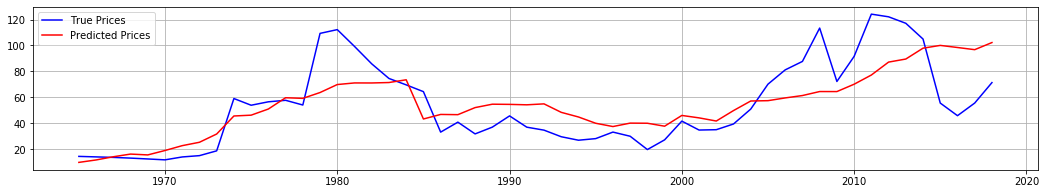

In [38]:
# Построим график истинных значений и прогнозных
y_pred = model_predict_(np.asarray(X_df.drop('index', axis=1)), lr_model)
x = X_df['index']

plt.figure(figsize=(18, 3))
lbl1 = 'True '+ cols[-1]
lbl2 = 'Predicted '+ cols[-1]
plt.plot(x, Y_df, "b", label=lbl1)
plt.plot(x, y_pred, "r", label=lbl2)
plt.legend()
plt.grid(True)

In [51]:
# Объединим данные в один датафрейм для анализа
task2_tbl_DF = regress_DF[0].join(regress_DF[2], on='index').join(trg_DF[1], on='index')
task2_tbl_DF = task2_tbl_DF.sort('index')

# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи регрессоров с целевым столбцом
cols = task2_tbl_DF.columns
for i in range(1,len(cols)-1):
    print('Correlation of {} and Coal Consumption is {:.3f}'.format(cols[i], task2_tbl_DF.corr(cols[3], cols[i])))

Correlation of Total World Oil Production and Coal Consumption is 0.942
Correlation of Total World Coal Production and Coal Consumption is 0.996


In [52]:
# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи между регрессорами
cols = task2_tbl_DF.columns
rng = range(1,len(cols))
for i in rng:
    output = ''
    for j in rng:
        corr_coef = task2_tbl_DF.corr(cols[i], cols[j])
        output = output + ('{:.3f}\t'.format(corr_coef))
    print(output)

1.000	0.930	0.942	
0.930	1.000	0.996	
0.942	0.996	1.000	


In [ ]:
Видно, что связь между двумя регрессорами весьма высока, поэтому увеличим число признаков по добыче угля и повторим проверки

In [39]:
# Выберем все столбцы, содержащие суммарную добычу угля по регионам мира кроме общемирового, и сформируем новый датасет
new_DF = spark.createDataFrame(data=regress_df[2])
tot_cols = [x for x in new_DF.columns if (r'Total' in x) and not (r'World' in x)]
tot_names = [x+' Coal Prod' for x in tot_cols]

buf = new_DF.select('index')
for i in range(len(tot_cols)):
    try:
        buf = buf.join(new_DF.select('index', f.col(tot_cols[i]).alias(tot_names[i])), on='index')
    except:
        tot_cols[i] = '`'+tot_cols[i]+'`'
        tot_names[i] = tot_names[i].replace('&', 'and').replace('S.', 'South').replace('Cent.', 'Central')
        buf = buf.join(new_DF.select('index', f.col(tot_cols[i]).alias(tot_names[i])), on='index')
    
new_DF = buf
task2_tbl_DF = regress_DF[0].join(new_DF, on='index').join(trg_DF[1], on='index')
task2_tbl_DF = task2_tbl_DF.sort('index')
#task2_tbl_DF.show()

In [144]:
# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи регрессоров с целевым столбцом
cols = task2_tbl_DF.columns
for i in range(1,len(cols)-1):
    print('Correlation of {} and {} is {:.3f}'.format(cols[i], cols[-1], task2_tbl_DF.corr(cols[-1], cols[i])))

Correlation of Total World Oil Production and Total World Coal Consumption is 0.942
Correlation of Total North America Coal Prod and Total World Coal Consumption is -0.161
Correlation of Total South and Central America Coal Prod and Total World Coal Consumption is 0.975
Correlation of Total Europe Coal Prod and Total World Coal Consumption is -0.812
Correlation of Total CIS Coal Prod and Total World Coal Consumption is -0.185
Correlation of Total Middle East Coal Prod and Total World Coal Consumption is 0.488
Correlation of Total Africa Coal Prod and Total World Coal Consumption is 0.903
Correlation of Total Asia Pacific Coal Prod and Total World Coal Consumption is 0.993


Заметна слабая отрицательная связь между добычей угля в Северной Америке и потреблением угля, между добычей угля в СНГ и потреблением угля, умеренная положительная связь между добычей угля на Ближнем Востоке и потреблением угля, а также сильная отрицательная связь между добычей угля в Европе и потреблением угля. В остальном - всё примерно на том же уровне.

In [181]:
# Вычислим коэффициенты корреляции Пирсона для проверки наличия статистической связи между регрессорами
cols = task2_tbl_DF.columns
rng = range(1,len(cols)-1)
lim = 0.85

prgBar = IntProgress(min = min(rng), max = max(rng))
display(prgBar)
print('Strong correlation between:')

for i in rng:
    prgBar.min = i
    prgBar.value = i
    prgBar.description = '{} step'.format(i)
    time.sleep(0.1)
    
    output = []
    for j in range(i+1,max(rng)+1):
        
        corr_coef = task2_tbl_DF.corr(cols[i], cols[j])
        if abs(corr_coef)>lim and i!=j:
            if not (cols[i] in output):
                output.append(cols[i])
            if not (cols[j] in output):
                output.append(cols[j])
        prgBar.value = j
        time.sleep(0.1)
                
    print(output)

IntProgress(value=1, max=8, min=1)

Strong correlation between:
['Total World Oil Production', 'Total South and Central America Coal Prod', 'Total Europe Coal Prod', 'Total Africa Coal Prod', 'Total Asia Pacific Coal Prod']
[]
['Total South and Central America Coal Prod', 'Total Europe Coal Prod', 'Total Africa Coal Prod', 'Total Asia Pacific Coal Prod']
['Total Europe Coal Prod', 'Total Africa Coal Prod']
[]
[]
['Total Africa Coal Prod', 'Total Asia Pacific Coal Prod']
[]


Видно, что связь между регрессорами весьма высока, кроме добычи угля в Северной Америке, СНГ и Ближнем Востоке, поэтому оставим их и добычу нефти в качестве регрессоров.

In [40]:
# Сформируем из столбцов-регрессоров один столбец признаков
cols = task2_tbl_DF.columns
vectorAssembler = VectorAssembler(inputCols = ['Total World Oil Production',
                                               'Total North America Coal Prod',
                                               'Total CIS Coal Prod',
                                               'Total Middle East Coal Prod'], outputCol = 'features')
vtask2_DF = vectorAssembler.transform(task2_tbl_DF)
# Возьмём столбец признаков и целевой столбец
vtask2_DF = vtask2_DF.select(['features', cols[-1]])

In [41]:
# Разобьём датасет на обучающее и тестовое подмножества
splits = vtask2_DF.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [42]:
# Обучим модель линейной регрессии и выведем коэффициенты полученной модели
lr = LinearRegression(featuresCol = 'features', labelCol=cols[-1], maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.406913872674544,1.4881847442323441,3.8068121483621606,134.28052018678366]
Intercept: -4015.7916769944395


In [43]:
# Выведем сумму квадратов регрессионных остатков и коэффициент детерминации
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 184.557405
r2: 0.927049


По коэффициенту детерминации можно заключить, что примерно 93% данных по потреблению угля (обучающей выборки) можно объяснить с помощью данной модели.

In [44]:
# Проверим модель на тестовых данных и выведем коэффициент детерминации
lr_predictions = lr_model.transform(test_df)
lr_predictions.select('prediction', cols[-1], 'features')
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=cols[-1],metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.892516


По коэффициенту детерминации можно заключить, что примерно 89% данных по потреблению угля (тестовой выборки) можно объяснить с помощью данной модели. Это значит, что модель не переобучена и даёт хороший прогноз по потреблению угля.

In [45]:
# Выведем сумму квадратов регрессионных остатков
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 228.544


In [46]:
# Сформируем датафрейм признаков и целевого показателя
X_df = task2_tbl_DF.select('index', 'Total World Oil Production','Total North America Coal Prod',
                           'Total CIS Coal Prod', 'Total Middle East Coal Prod').toPandas()
Y_df = task2_tbl_DF.select(cols[-1]).toPandas()

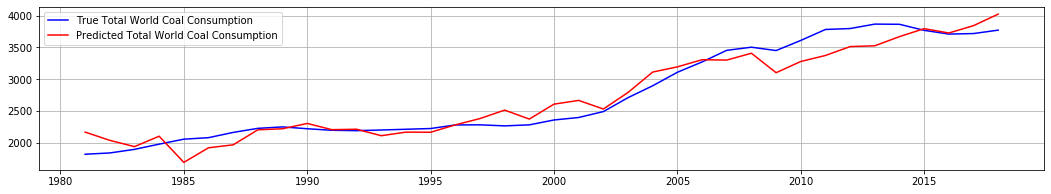

In [47]:
# Построим график истинных значений и прогнозных
y_pred = model_predict_(np.asarray(X_df.drop('index', axis=1)), lr_model)
x = X_df['index']

plt.figure(figsize=(18, 3))
lbl1 = 'True '+ cols[-1]
lbl2 = 'Predicted '+ cols[-1]
plt.plot(x, Y_df, "b", label=lbl1)
plt.plot(x, y_pred, "r", label=lbl2)
plt.legend()
plt.grid(True)

### 1.3 Кластеризация с Apache Spark

In [66]:
# Подготавливаем необходимую информацию для импорта целевых данных:
# потребление энергии из различных источников (нефть, газ, уголь, ядерное топливо, вода, возобновляемые источники)
sheets = 'Primary Energy - Cons by fuel'
header_ = 2
usecols_ = 'A:O'
skiprows_ = list(range(89,97))

# Импорт файла
prim_en_consum_df = pd.read_excel(filename, sheet_name=sheets, header=header_, usecols=usecols_, skiprows=skiprows_)

prim_en_consum_df.dropna(inplace=True, how='all')
prim_en_consum_df.reset_index(inplace=True, drop=True)

In [83]:
# Изменим названия столбцов и подправим некорректные имена
cols = prim_en_consum_df.columns
for col in cols:
    if '.1' in col:
        new_col_name = col.replace('.1', '_new')
        prim_en_consum_df.rename(columns={col: new_col_name}, inplace=True)
    if '- ' in col:
        new_col_name = col.replace('- ', '')
        prim_en_consum_df.rename(columns={col: new_col_name}, inplace=True)

In [84]:
# Создадим датафреймы Spark
prim_DF = spark.createDataFrame(data=prim_en_consum_df)

In [132]:
# Разобьём датафрейм на два: за 2017 (prim_old_DF) и за 2018 (prim_new_DF) года
cols = prim_DF.columns
new_cols = [str(col) for col in cols if ('_new' in col) and not ('Total' in col)]
old_cols = [str(col) for col in cols if not ('_new' in col) and not ('Total' in col)]
prim_new_DF = prim_DF.select(cols[0], *new_cols)
prim_old_DF = prim_DF.select(*old_cols)

In [133]:
prim_new_DF.printSchema()

root
 |-- Million tonnes oil equivalent: string (nullable = true)
 |-- Oil_new: double (nullable = true)
 |-- Natural Gas_new: double (nullable = true)
 |-- Coal_new: double (nullable = true)
 |-- Nuclear energy_new: double (nullable = true)
 |-- Hydro electric_new: double (nullable = true)
 |-- Renewables_new: double (nullable = true)



In [134]:
prim_old_DF.printSchema()

root
 |-- Million tonnes oil equivalent: string (nullable = true)
 |-- Oil: double (nullable = true)
 |-- Natural Gas: double (nullable = true)
 |-- Coal: double (nullable = true)
 |-- Nuclear energy: double (nullable = true)
 |-- Hydro electric: double (nullable = true)
 |-- Renewables: double (nullable = true)



In [135]:
# Нам нужно хранить все объекты в виде массива, а этот массив хранить в виде столбца под названием "features".
# Поскольку нам больше не нужны исходные столбцы, мы отфильтровываем их с помощью оператора select.
cols = prim_new_DF.columns
vecAssembler = VectorAssembler(inputCols=cols[1:], outputCol="features")
df_kmeans = vecAssembler.transform(prim_new_DF).select(cols[0], 'features')
df_kmeans.show(5)

+-----------------------------+--------------------+
|Million tonnes oil equivalent|            features|
+-----------------------------+--------------------+
|                       Canada|[109.974271205922...|
|                       Mexico|[82.8240326843597...|
|                           US|[919.729512949020...|
|          Total North America|[1112.52781683930...|
|                    Argentina|[30.1137787909599...|
+-----------------------------+--------------------+
only showing top 5 rows



IntProgress(value=2, description='Progress:', max=10, min=2)

Text(0, 0.5, 'cost')

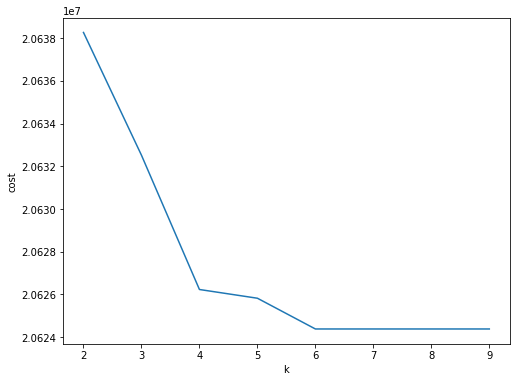

In [138]:
# Чтобы оптимизировать выбор k кластеров, сгруппируем часть данных для различных вариантов k
# и найдём оптимальное k по правилу "локтя".
max_k = 10
cost = np.zeros(max_k)
prgBar = IntProgress(min = 2, max = len(cost)-1, description='Progress:')
display(prgBar)

for k in range(2,max_k):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans)
    
    prgBar.value = k
    time.sleep(0.1)

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,max_k),cost[2:max_k])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Как видно, начиная с *k* = 6, функционал перестаёт визуально уменьшаться, поэтому остановим свой выбор на *k* = 6.

In [139]:
# Обучим модель
k = 6
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

# Координаты центроидов
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[29.3541905  20.95928098 11.54259442  3.45934231  5.51058335  2.86084134]
[ 641.21207428  243.33272696 1906.725        66.60632665  272.07992035
  143.50895184]
[1695.36051414  709.64969412 2841.34689344  125.26239354  388.85557425
  225.36532701]
[924.74346973 684.553311   322.48215071 207.43618941 123.63105763
 131.59855168]
[252.63963834 455.2528123   76.95640181  31.53355458  33.9595651
   0.84805712]
[166.4779223   96.79258601  89.37062172  10.2735542   42.77368394
  18.17752088]


In [140]:
# Добавим столбец с прогнозными данными в исходный датафрейм
# Для начала с помощью метода transform получим прогнозные значения
transformed = model.transform(df_kmeans).select(cols[0], 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(Million tonnes oil equivalent='Canada', prediction=5), Row(Million tonnes oil equivalent='Mexico', prediction=0), Row(Million tonnes oil equivalent='US', prediction=3)]


In [141]:
# Создадим датафрейм из полученных строк
df_pred = spark.createDataFrame(rows)
df_pred.show()

+-----------------------------+----------+
|Million tonnes oil equivalent|prediction|
+-----------------------------+----------+
|                       Canada|         5|
|                       Mexico|         0|
|                           US|         3|
|          Total North America|         3|
|                    Argentina|         0|
|                       Brazil|         5|
|                        Chile|         0|
|                     Colombia|         0|
|                      Ecuador|         0|
|                         Peru|         0|
|            Trinidad & Tobago|         0|
|                    Venezuela|         0|
|         Other S. & Cent. ...|         0|
|         Total S. & Cent. ...|         5|
|                      Austria|         0|
|                      Belgium|         0|
|               Czech Republic|         0|
|                      Finland|         0|
|                       France|         0|
|                      Germany|         5|
+----------

In [142]:
# Соединим два датафрейма
df_pred = df_pred.join(prim_new_DF, cols[0])
pddf_pred = df_pred.toPandas().set_index(cols[0])
pddf_pred.head()

,prediction,Oil_new,Natural Gas_new,Coal_new,Nuclear energy_new,Hydro electric_new,Renewables_new
Million tonnes oil equivalent,,,,,,,
Sweden,0,14.834876,0.698266,1.968162,15.523328,14.010245,6.572206
Philippines,0,21.959384,3.515741,16.277785,0.000000,2.123310,3.154765
Malaysia,0,36.884767,35.490471,21.122196,0.000000,5.470538,0.331274
Singapore,0,75.820951,10.564301,0.912613,0.000000,0.000000,0.268585
Turkey,0,48.564390,40.669133,42.308652,0.000000,13.467503,8.530610


In [143]:
# Для визуализации уменьшим размерность исходных данных
cols = pddf_pred.columns
pca = PCA(n_components=3)
pca_result = pca.fit_transform(pddf_pred[cols[1:]].values)
df = pd.DataFrame(data=pddf_pred[cols[0]], index=pddf_pred.index)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.85617783 0.13027911 0.00926776]


In [144]:
df.head()

,prediction,pca-one,pca-two,pca-three
Million tonnes oil equivalent,,,,
Sweden,0,-152.195484,-52.754937,-14.106607
Philippines,0,-138.945812,-57.822251,-10.076636
Malaysia,0,-118.614780,-33.059505,5.344468
Singapore,0,-121.530628,-16.725218,-40.132799
Turkey,0,-92.708620,-35.389703,4.008339


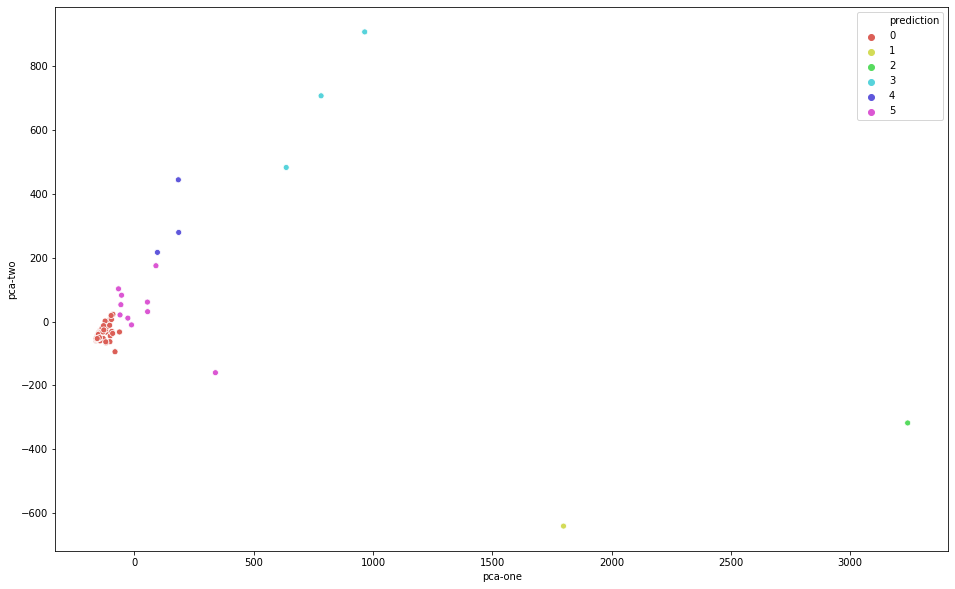

In [145]:
# Построим график проекции исходных данных на плоскость и
# присвоим каждой точке (отдельной стране или региону) цвет, соответствующий кластеру
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pca-one', y='pca-two',
    hue='prediction',
    palette=sns.color_palette('hls', k),
    data=df,
    legend="full"
)

In [164]:
# Выведем представителей малочисленных кластеров
pddf_pred[(pddf_pred['prediction']==1)+
          (pddf_pred['prediction']==2)+
          (pddf_pred['prediction']==3)+
          (pddf_pred['prediction']==4)]

,prediction,Oil,Natural Gas,Coal,Nuclear energy,Hydro electric,Renewables
Million tonnes oil equivalent,,,,,,,
Total Europe,3,746.162942,481.898943,315.538177,211.821276,132.345905,162.256051
China,1,610.683589,206.739785,1890.425612,56.138842,263.626284,111.417194
US,3,901.997187,635.805709,331.263340,191.726344,67.159948,94.528165
Russian Federation,4,151.511400,370.679786,83.930000,45.966776,41.932780,0.258653
Total CIS,4,191.146312,472.310072,126.424899,46.559526,54.339558,0.463072
Total Asia Pacific,2,1651.336852,660.642061,2770.842789,111.741349,373.228763,180.246691
Total North America,3,1096.613710,804.415691,365.075585,216.908916,164.084871,108.379269
Total Middle East,4,412.489702,453.168903,8.167409,1.600572,4.703821,1.254566


Здесь можно заметить, что в четвёртый кластер попали страны и регионы, в которых, в частности, очень мало потребление энергии из возобновляемых источников энергии: Россия, СНГ и Ближний Восток.

In [146]:
# Проведём аналогично кластеризацию данных за 2017 год
cols = prim_old_DF.columns
vecAssembler = VectorAssembler(inputCols=cols[1:], outputCol="features")
df_kmeans = vecAssembler.transform(prim_old_DF).select(cols[0], 'features')

In [147]:
k = 6
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[29.19319839 20.66884976 11.18862942  3.43478064  5.17738462  2.63300307]
[ 610.68358924  206.73978501 1890.425612     56.13884238  263.62628411
  111.41719373]
[1651.33685163  660.64206115 2770.84278919  111.74134907  373.22876281
  180.24669055]
[914.92461298 640.70678117 337.29236729 206.81884512 121.19690808
 121.72116144]
[251.71580482 432.05292028  72.84076927  31.37562464  33.65871977
   0.65876352]
[167.12818255  93.73239142  86.27061569  10.2286489   42.25743825
  16.10253269]


In [148]:
transformed = model.transform(df_kmeans).select(cols[0], 'prediction')
rows = transformed.collect()

df_pred = spark.createDataFrame(rows)

df_pred = df_pred.join(prim_old_DF, cols[0])
pddf_pred = df_pred.toPandas().set_index(cols[0])

[Row(Million tonnes oil equivalent='Canada', prediction=5), Row(Million tonnes oil equivalent='Mexico', prediction=0), Row(Million tonnes oil equivalent='US', prediction=3)]


In [151]:
cols = pddf_pred.columns
pca = PCA(n_components=3)
pca_result = pca.fit_transform(pddf_pred[cols[1:]].values)
df2 = pd.DataFrame(data=pddf_pred[cols[0]], index=pddf_pred.index)
df2['pca-one'] = pca_result[:,0]
df2['pca-two'] = pca_result[:,1] 
df2['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.85850136 0.12831689 0.00880108]


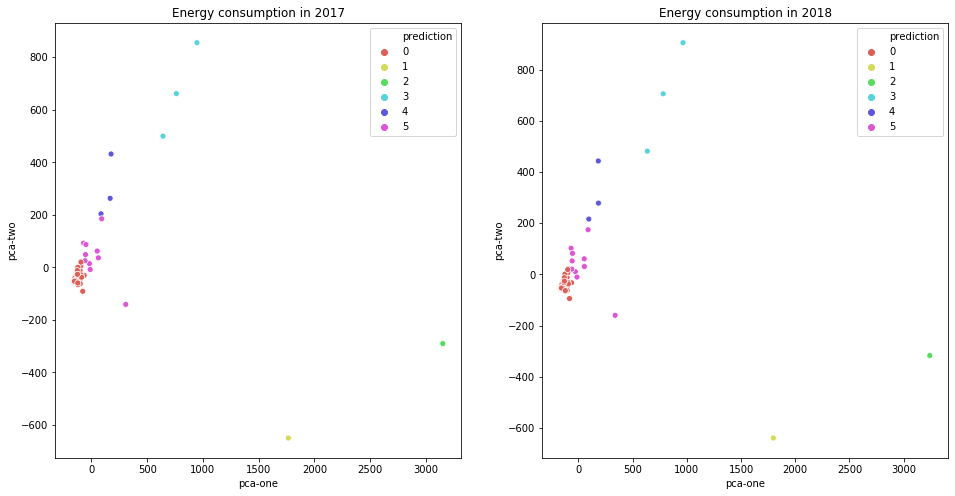

In [152]:
# Визуализируем результаты кластеризации для данных за 2017 и 2018 года
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Energy consumption in 2017')
sns.scatterplot(
    x='pca-one', y='pca-two',
    hue='prediction',
    palette=sns.color_palette('hls', k),
    data=df2,
    legend="full"
)
plt.subplot(122)
plt.title('Energy consumption in 2018')
sns.scatterplot(
    x='pca-one', y='pca-two',
    hue='prediction',
    palette=sns.color_palette('hls', k),
    data=df,
    legend="full"
)

Как видно, за год представители малочисленных кластеров не поменяли кластеры. Визуально ситуация в 2018 в целом осталась такой же, какой была в 2017 году.